# 0. Imports and constants (run config)

In [1]:
from copulae.archimedean import ClaytonCopula, FrankCopula, GumbelCopula
from copulae.elliptical import GaussianCopula, StudentCopula
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import Pipeline
from statsmodels.nonparametric.bandwidths import bw_silverman, bw_scott

from components.transformers.rate_transformer import RateTransformer
from components.transformers.log_transformer import LognTransformer

In [2]:
X_TRAIN_START = '2010-01-01'
X_TRAIN_END = '2022-12-30'
X_TEST_START = '2023-01-02'
X_TEST_END = '2023-02-28'


SELECTED_PORTFOLIOS = {
    'P1': ['Nickel', 'Copper'],
    'P2': ['Brent Oil', 'Gas US'],
    'P3': ['Gold', 'Silver'],
    'P4': ['Nickel', 'Copper', 'Gold'],
    'P5': ['Nickel', 'Copper', 'Silver'],
    'P6': ['Brent Oil', 'Gas US', 'Gold'],
    'P7': ['Brent Oil', 'Gas US', 'Silver']
}

SELECTED_BENCHMARK = 'SPGSCI'

# KDE configuration
# 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine',
KERNEL = 'epanechnikov'
# 'silverman', 'scott', float
KERNEL_BANDWIDTH = 'silverman'

# Copula
# 'gaussian', 'student', 'frank', 'clayton', 'gumbel'
COPULA = 'student'
N_COPULA_SIMULATIONS = 10000
RANDOM_SEED = 5

# Portfolio simulations
WEIGHT_SIMULATIONS = 10000

# 1. Data load and prep

In [3]:
# load prices from dataset
df = pd.read_excel('data/BazaMSA.xlsx', sheet_name='Ceny')
# Dates as index
df.set_index('Dates', inplace=True)

# Comprehensive scikitlearn `Pipeline` that first creates the rates
# and then performs logn on top
log_rate_pipe = Pipeline(
    steps=[
        ('rates', RateTransformer(period=1)),
        ('logn', LognTransformer())
    ]
)
df_transformed = log_rate_pipe.fit_transform(X=df)
# Drop all the `na` values
df_transformed.dropna(inplace=True)

# Select dataset to train (fit) and test
X_train = df_transformed.loc[X_TRAIN_START:X_TRAIN_END]
X_test = df_transformed.loc[X_TEST_START:X_TEST_END]

f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


# 2. Kernel density estimation

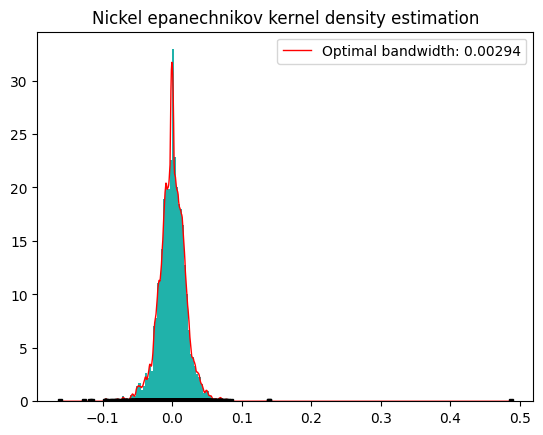

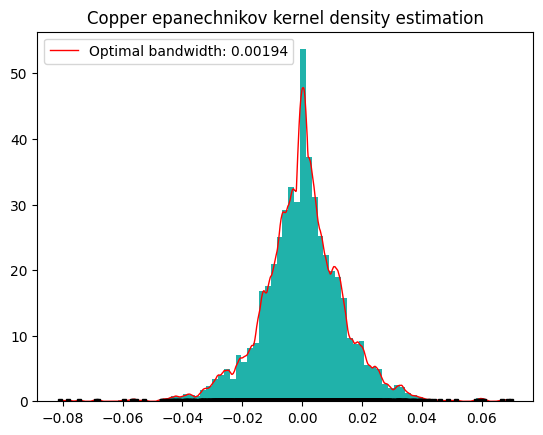

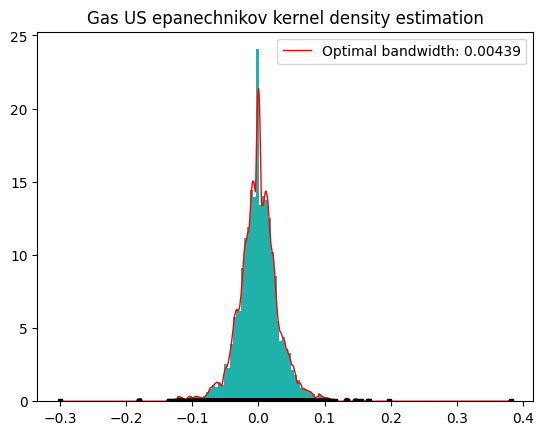

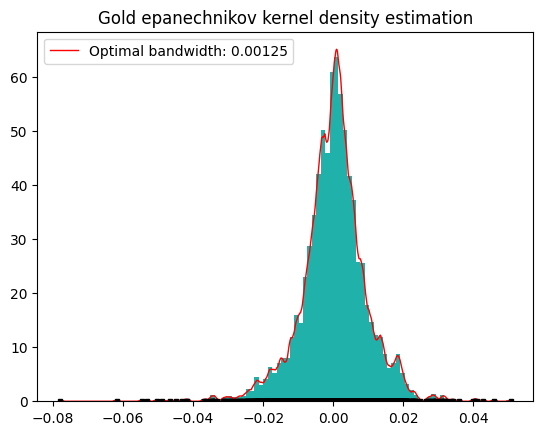

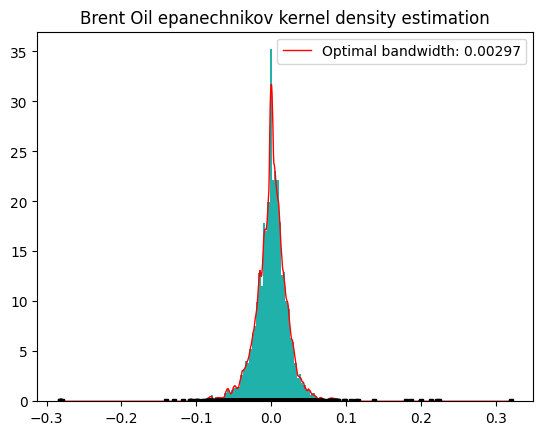

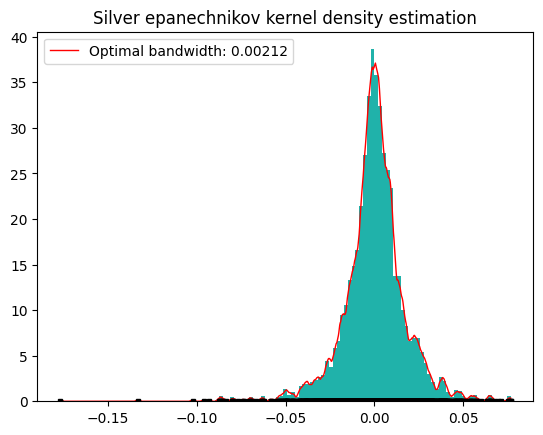

In [4]:
df_kernel = pd.DataFrame()
for asset in set([i for j in SELECTED_PORTFOLIOS.values() for i in j]):
    # KernelDensity requires 2D array, so need to reshape
    dist = X_train[asset].to_numpy().reshape(-1, 1)

    optimized_metrics = {}
    optimized_metrics['silverman'] = bw_silverman(X_train[asset])
    optimized_metrics['scott'] = bw_scott(X_train[asset])

    if KERNEL_BANDWIDTH in ['silverman', 'scott']:
        bandwidth = optimized_metrics[KERNEL_BANDWIDTH]
    else:
        bandwidth = KERNEL_BANDWIDTH

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    # fitting KDE
    kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
    # compute the log-likelihood of each sample
    log_density = kde.score_samples(x_range.reshape(-1,1))
    # df_bandwidth[bandwidth] = log_density

    plt.title(f'{asset} {KERNEL} kernel density estimation')
    plt.hist(X_train[asset], density=True, color='lightseagreen', bins='auto')
    plt.plot(x_range, np.exp(log_density), color='red', linewidth=1, label=f'Optimal bandwidth: {round(bandwidth,5)}')
    plt.plot(dist, np.zeros_like(dist) , 's', markersize=3, color='black')
    plt.legend()
    plt.show()

    df_kernel[asset] = log_density

# 3. Copula

In [5]:
copula_simulations_dfs = {}
copula_simulations_sigma = {}
for portfolio, assets in SELECTED_PORTFOLIOS.items():
    print(f'Portfolio_id: {portfolio}, assets: {assets}')
    copula_dict = {
        'gaussian': GaussianCopula(dim=len(assets)),
        'student': StudentCopula(dim=len(assets)),
        'frank': FrankCopula(dim=len(assets)),
        'clayton': ClaytonCopula(dim=len(assets)),
        'gumbel': GumbelCopula(dim=len(assets))
    }
    copula = copula_dict[COPULA]
    copula.fit(df_kernel[assets], to_pobs=True, verbose=0)
    print(copula.summary())
    
    copula_simulations_dfs[portfolio] = copula.random(n=N_COPULA_SIMULATIONS, seed=RANDOM_SEED)
    copula_simulations_sigma[portfolio] = copula.sigma

Portfolio_id: P1, assets: ['Nickel', 'Copper']
            Nickel       Copper
count  1000.000000  1000.000000
mean      0.500000     0.500000
std       0.240804     0.288433
min       0.336164     0.044456
25%       0.336164     0.250500
50%       0.336164     0.500000
75%       0.749500     0.749500
max       0.999001     0.999001
Student Copula Summary
Student Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 175.83361811053456

 Correlation Matrix 
 1.000000 -0.329482
-0.329482  1.000000

Portfolio_id: P2, assets: ['Brent Oil', 'Gas US']
         Brent Oil       Gas US
count  1000.000000  1000.000000
mean      0.500000     0.500000
std       0.267854     0.267097
min       0.258741     0.261738
25%       0.258741     0.261738
50%       0.258741     0.261738
75%       0.749500     0.749500
max       0.999001     0.999001
Student Copula Summary
Student Copula with 2 dimensions


Parameters
----

f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:195: RuntimeWarning: divide by zero encountered in divide
  r /= d


              Gold       Silver
count  1000.000000  1000.000000
mean      0.500000     0.500000
std       0.287443     0.285548
min       0.098402     0.137363
25%       0.250500     0.137363
50%       0.500000     0.500000
75%       0.749500     0.749500
max       0.999001     0.999001
Student Copula Summary
Student Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 195.13114238201013

 Correlation Matrix 
1.000000 0.763639
0.763639 1.000000

Portfolio_id: P4, assets: ['Nickel', 'Copper', 'Gold']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


            Nickel       Copper         Gold
count  1000.000000  1000.000000  1000.000000
mean      0.500000     0.500000     0.500000
std       0.240804     0.288433     0.287443
min       0.336164     0.044456     0.098402
25%       0.336164     0.250500     0.250500
50%       0.336164     0.500000     0.500000
75%       0.749500     0.749500     0.749500
max       0.999001     0.999001     0.999001
Student Copula Summary
Student Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 907.4062678084796

 Correlation Matrix 
 1.000000 -0.334944 -0.484313
-0.334944  1.000000  0.799818
-0.484313  0.799818  1.000000

Portfolio_id: P5, assets: ['Nickel', 'Copper', 'Silver']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


            Nickel       Copper       Silver
count  1000.000000  1000.000000  1000.000000
mean      0.500000     0.500000     0.500000
std       0.240804     0.288433     0.285548
min       0.336164     0.044456     0.137363
25%       0.336164     0.250500     0.137363
50%       0.336164     0.500000     0.500000
75%       0.749500     0.749500     0.749500
max       0.999001     0.999001     0.999001
Student Copula Summary
Student Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 717.2376585936788

 Correlation Matrix 
 1.000000 -0.319564 -0.694188
-0.319564  1.000000  0.508510
-0.694188  0.508510  1.000000

Portfolio_id: P6, assets: ['Brent Oil', 'Gas US', 'Gold']
         Brent Oil       Gas US         Gold
count  1000.000000  1000.000000  1000.000000
mean      0.500000     0.500000     0.500000
std       0.267854     0.267097     0.287443
min       0.258741     0.261738     0.098402
25%      

# 4. Portfolio weight optimizations for classical Markowitz and Semiparametric

In [6]:
np.random.seed(RANDOM_SEED)

markowitz_weights = {}
copula_weights = {}
for portfolio, assets in SELECTED_PORTFOLIOS.items():
    # classic markowitz
    returns_markowitz = X_train[assets].mean()
    cov_markowitz = X_train[assets].cov()
    ef_markowitz = EfficientFrontier(returns_markowitz, cov_markowitz)
    raw_weights_markowitz = ef_markowitz.max_sharpe(risk_free_rate=0)
    cleaned_weights_markowitz = ef_markowitz.clean_weights()
    opt_weights_markowitz = np.array([weight for weight in cleaned_weights_markowitz.values()])
    markowitz_weights[portfolio] = opt_weights_markowitz

    # copula
    returns_copula = copula_simulations_dfs[portfolio].mean()
    dependency_matrix_copula = pd.DataFrame(copula_simulations_sigma[portfolio])
    dependency_matrix_copula.columns, dependency_matrix_copula.index = assets, assets
    cov_copula = risk_models.corr_to_cov(dependency_matrix_copula, stdevs=copula_simulations_dfs[portfolio].std())
    ef_copula = EfficientFrontier(returns_copula, cov_copula)
    raw_weights_copula = ef_copula.max_sharpe()
    cleaned_weights_copula = ef_copula.clean_weights()
    opt_weights_copula = np.array([weight for weight in cleaned_weights_copula.values()])
    copula_weights[portfolio] = opt_weights_copula


# 5. Portfolio testing

P1


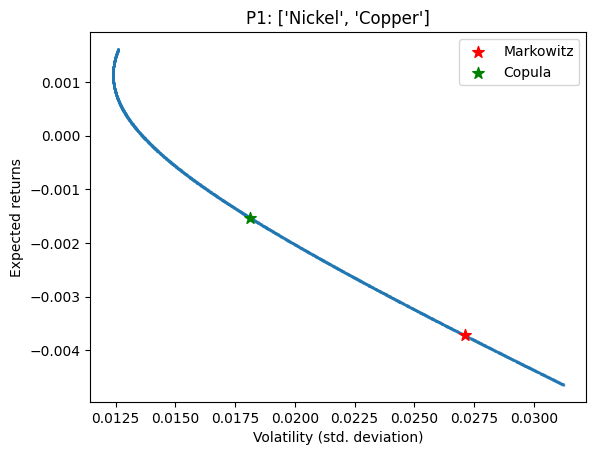

P2


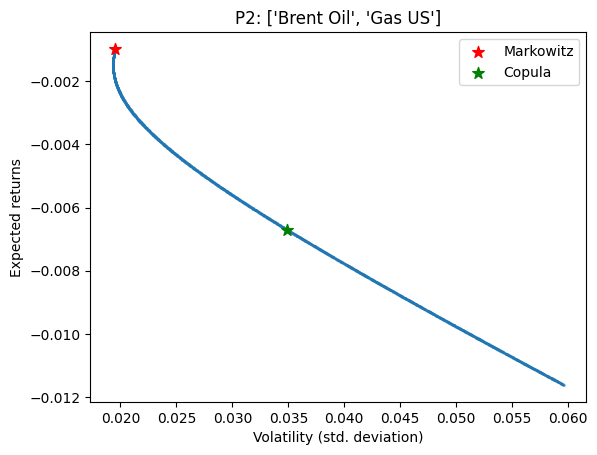

P3


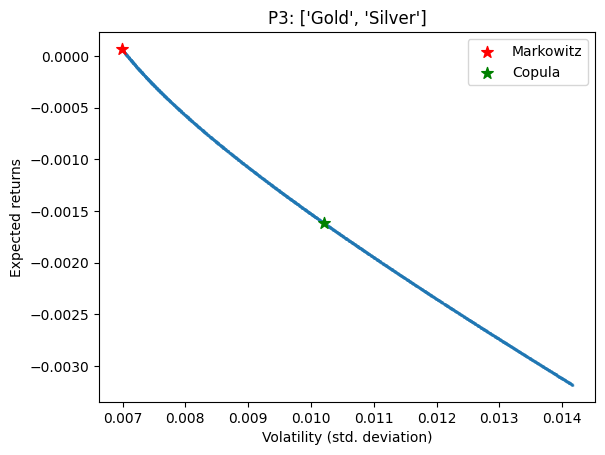

P4


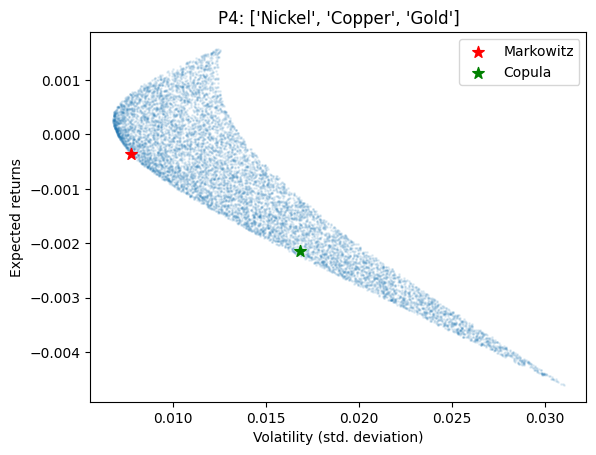

P5


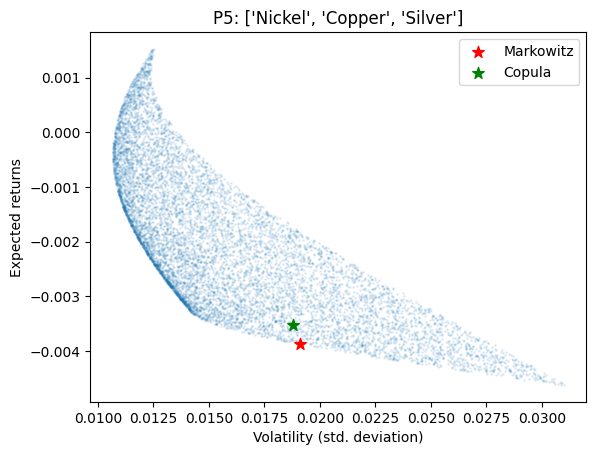

P6


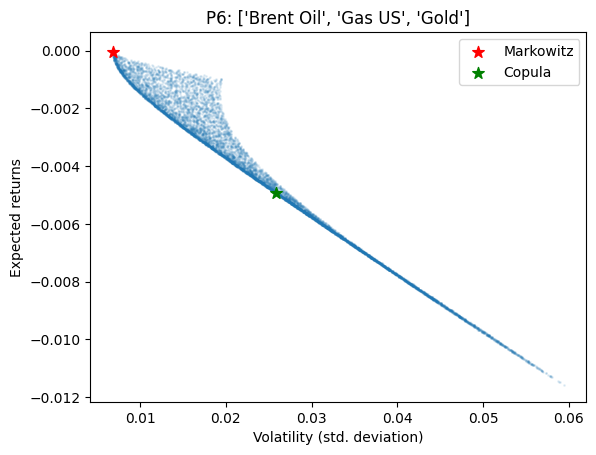

P7


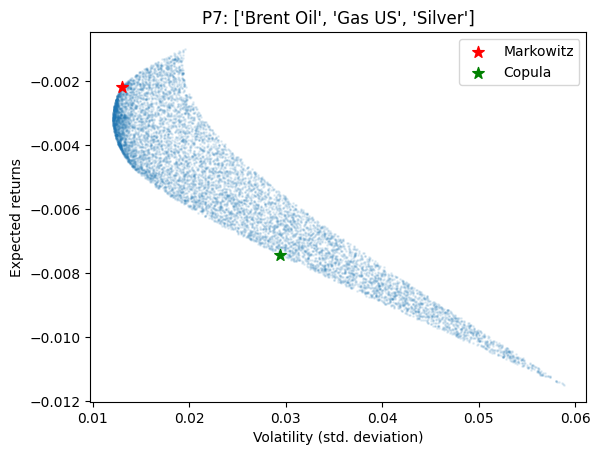

In [7]:
np.random.seed(RANDOM_SEED)

testing_df = pd.DataFrame()
for portfolio, assets in SELECTED_PORTFOLIOS.items():
    testing_portfolio = X_test[assets]
    print(portfolio)
    testing_markowitz_return = (markowitz_weights[portfolio]*np.array(testing_portfolio.mean())).sum()
    testing_markowitz_volatility = np.sqrt(
        np.dot(markowitz_weights[portfolio].T, np.dot(testing_portfolio.cov(), markowitz_weights[portfolio])))
    
    testing_copula_return = (copula_weights[portfolio]*np.array(testing_portfolio.mean())).sum()
    testing_copula_volatility = np.sqrt(
        np.dot(copula_weights[portfolio].T, np.dot(testing_portfolio.cov(), copula_weights[portfolio])))
    row = pd.DataFrame({
        'Portfolio': [portfolio],
        'Assets': [assets],
        'Markowitz weights': [markowitz_weights[portfolio]],
        'Copula weights': [copula_weights[portfolio]],
        'Markowitz return': [testing_markowitz_return],
        'Copula return': [testing_copula_return],
        'Markowitz volatility': [testing_markowitz_return],
        'Copula volatility': [testing_copula_volatility]
    })
    testing_df = pd.concat([testing_df, row], ignore_index=True)


    simulated_df = pd.DataFrame()
    for i in range(0, WEIGHT_SIMULATIONS):
        weight_sim = np.random.dirichlet(np.ones(len(assets)), size=1)[0]

        portfolio_return = (weight_sim*np.array(testing_portfolio.mean())).sum()
        portfolio_volatility = np.sqrt(np.dot(weight_sim.T, np.dot(testing_portfolio.cov(), weight_sim)))

        row = pd.DataFrame({
            'weights': [weight_sim],
            'exp_return': [portfolio_return],
            'volatility': [portfolio_volatility]
        })
        simulated_df = pd.concat([simulated_df, row], ignore_index=True)

    plt.title(f'{portfolio}: {assets}')
    plt.scatter(x=simulated_df['volatility'], y=simulated_df['exp_return'], alpha=0.1, s=1)
    plt.scatter(x=testing_markowitz_volatility, y=testing_markowitz_return, s=75, marker='*', color='red', label='Markowitz')
    plt.scatter(x=testing_copula_volatility, y=testing_copula_return, s=75, marker='*', color='green', label='Copula')
    plt.xlabel('Volatility (std. deviation)')
    plt.ylabel('Expected returns')
    plt.legend()
   # plt.title(f'Optimal weights: {printable_weights}\n'
   #         f'Exp return: {round(opt_return,3)}, Volatility: {round(opt_volatility,3)}')
    plt.show()


benchmark = X_test[SELECTED_BENCHMARK]
benchmark_return = benchmark.mean()
benchmark_volatility = benchmark.std()
testing_df[f'Benchmark: {SELECTED_BENCHMARK} return'] = benchmark_return
testing_df[f'Benchmark: {SELECTED_BENCHMARK} volatility'] = benchmark_volatility

In [8]:
testing_df

,Portfolio,Assets,Markowitz weights,Copula weights,Markowitz return,Copula return,Markowitz volatility,Copula volatility,Benchmark: SPGSCI return,Benchmark: SPGSCI volatility
0,P1,"[Nickel, Copper]","[0.85243, 0.14757]","[0.50266, 0.49734]",-0.003720,-0.001532,-0.003720,0.018129,-0.001127,0.012666
1,P2,"[Brent Oil, Gas US]","[1.0, 0.0]","[0.46183, 0.53817]",-0.000972,-0.006702,-0.000972,0.034892,-0.001127,0.012666
2,P3,"[Gold, Silver]","[1.0, 0.0]","[0.48134, 0.51866]",0.000070,-0.001618,0.000070,0.010211,-0.001127,0.012666
3,P4,"[Nickel, Copper, Gold]","[0.09153, 0.0, 0.90847]","[0.49145, 0.07082, 0.43773]",-0.000362,-0.002137,-0.000362,0.016853,-0.001127,0.012666
4,P5,"[Nickel, Copper, Silver]","[0.47321, 0.0, 0.52679]","[0.48177, 0.07669, 0.44154]",-0.003874,-0.003519,-0.003874,0.018801,-0.001127,0.012666
5,P6,"[Brent Oil, Gas US, Gold]","[0.1055, 0.0, 0.8945]","[0.09794, 0.42017, 0.48189]",-0.000040,-0.004944,-0.000040,0.025895,-0.001127,0.012666
6,P7,"[Brent Oil, Gas US, Silver]","[0.46099, 0.0, 0.53901]","[0.0, 0.50232, 0.49768]",-0.002164,-0.007421,-0.002164,0.029413,-0.001127,0.012666
